In [1]:
!pip install -U transformers datasets scikit-learn

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 33.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 17.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 22.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2025.3.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which 

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/584 [00:00<?, ?B/s]

pytorch_model.bin.index.json:   0%|          | 0.00/22.5k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

pytorch_model-00002-of-00002.bin:   0%|          | 0.00/3.85G [00:00<?, ?B/s]

pytorch_model-00001-of-00002.bin:   0%|          | 0.00/9.97G [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/23.6k [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at deepseek-ai/deepseek-llm-7b-base and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Map:   0%|          | 0/1267 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-2-19bd0f6b3790>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



LIAR — Best Threshold based on F1:
Threshold    0.350000
Precision    0.399010
Recall       0.897550
F1           0.552433
Accuracy     0.484609
Name: 5, dtype: float64


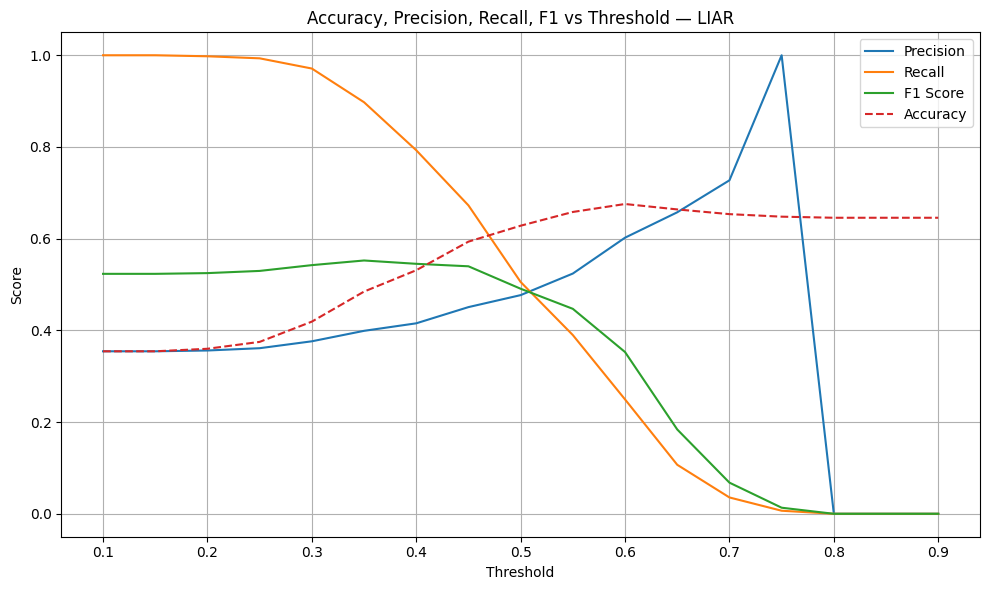

LIAR AUROC: 0.6597


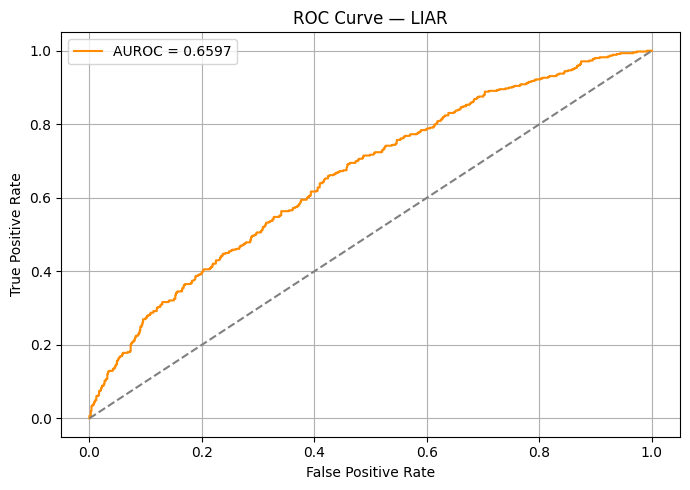

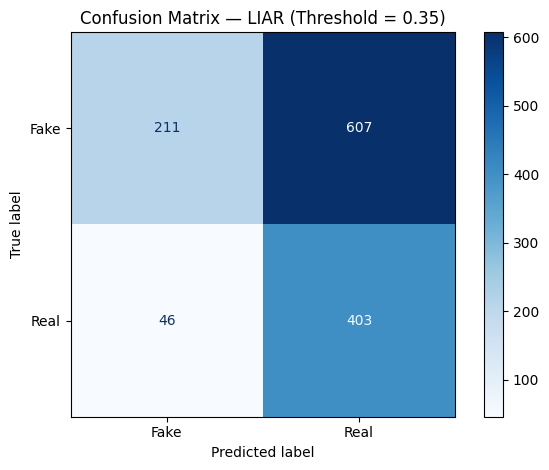

Map:   0%|          | 0/85 [00:00<?, ? examples/s]

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-2-19bd0f6b3790>:45: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(model=model, args=args, tokenizer=tokenizer)
No label_names provided for model class `PeftModelForSequenceClassification`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.



FakeNewsNet — Best Threshold based on F1:
Threshold    0.300000
Precision    0.500000
Recall       1.000000
F1           0.666667
Accuracy     0.505882
Name: 4, dtype: float64


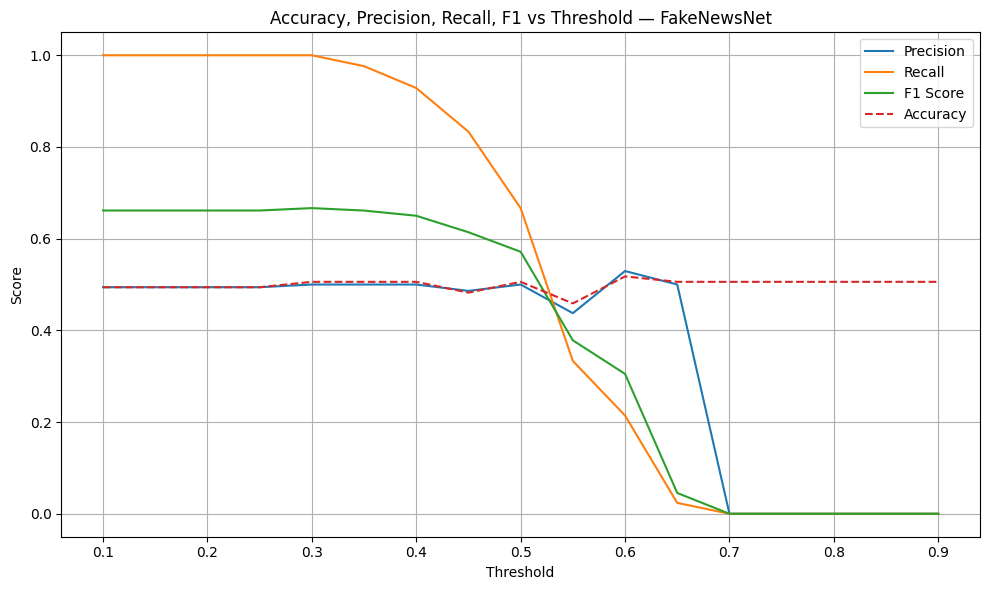

FakeNewsNet AUROC: 0.4776


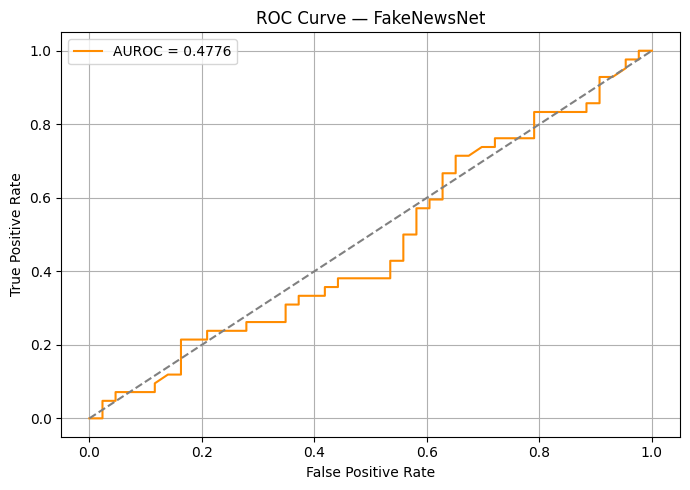

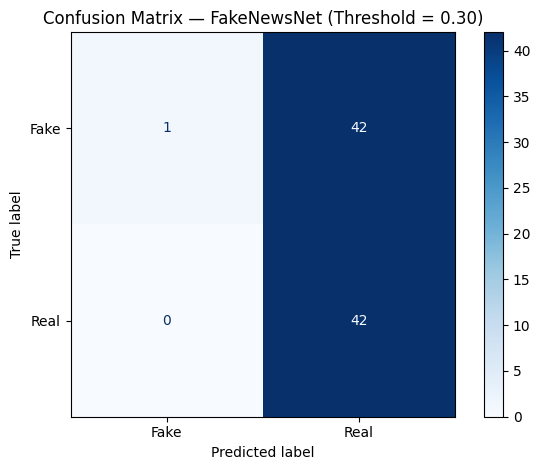

In [2]:
import os
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments
from peft import PeftModel
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    roc_auc_score, roc_curve, confusion_matrix, ConfusionMatrixDisplay
)

os.environ["WANDB_DISABLED"] = "true"

model_path = "/content/drive/MyDrive/misinfo_project/models/deepseek_lora_final"
tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
tokenizer.pad_token = tokenizer.eos_token

base_model = AutoModelForSequenceClassification.from_pretrained(
    "deepseek-ai/deepseek-llm-7b-base",
    device_map="auto",
    trust_remote_code=True,
    torch_dtype=torch.float16,
    num_labels=2,
    offload_folder="./offload_eval"
)

model = PeftModel.from_pretrained(base_model, model_path)
model.config.pad_token_id = tokenizer.pad_token_id
model.eval()

def evaluate_thresholds_and_roc(df_path, dataset_name):
    df = pd.read_csv(df_path).dropna(subset=["text", "label"])
    df["label"] = df["label"].astype(int)

    def tokenize(example):
        return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

    dataset = Dataset.from_pandas(df).map(tokenize, batched=True)
    dataset = dataset.remove_columns(["text"])
    dataset.set_format("torch")

    args = TrainingArguments(output_dir="./eval_temp", per_device_eval_batch_size=4, fp16=True)
    trainer = Trainer(model=model, args=args, tokenizer=tokenizer)
    predictions = trainer.predict(dataset)

    probs = torch.softmax(torch.tensor(predictions.predictions), dim=1)[:, 1].numpy()
    labels = predictions.label_ids

    thresholds = np.arange(0.1, 0.95, 0.05)
    metrics = []
    for t in thresholds:
        preds = (probs >= t).astype(int)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="binary", zero_division=0)
        acc = accuracy_score(labels, preds)
        metrics.append((t, precision, recall, f1, acc))

    df_metrics = pd.DataFrame(metrics, columns=["Threshold", "Precision", "Recall", "F1", "Accuracy"])
    best = df_metrics.iloc[df_metrics["F1"].idxmax()]
    best_threshold = best["Threshold"]

    print(f"\n{dataset_name} — Best Threshold based on F1:")
    print(best)

    plt.figure(figsize=(10, 6))
    plt.plot(df_metrics["Threshold"], df_metrics["Precision"], label="Precision")
    plt.plot(df_metrics["Threshold"], df_metrics["Recall"], label="Recall")
    plt.plot(df_metrics["Threshold"], df_metrics["F1"], label="F1 Score")
    plt.plot(df_metrics["Threshold"], df_metrics["Accuracy"], label="Accuracy", linestyle="--")
    plt.xlabel("Threshold")
    plt.ylabel("Score")
    plt.title(f"Accuracy, Precision, Recall, F1 vs Threshold — {dataset_name}")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    auroc = roc_auc_score(labels, probs)
    fpr, tpr, _ = roc_curve(labels, probs)

    print(f"{dataset_name} AUROC: {auroc:.4f}")

    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f"AUROC = {auroc:.4f}", color="darkorange")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"ROC Curve — {dataset_name}")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    best_preds = (probs >= best_threshold).astype(int)
    cm = confusion_matrix(labels, best_preds)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Fake", "Real"])
    disp.plot(cmap="Blues")
    plt.title(f"Confusion Matrix — {dataset_name} (Threshold = {best_threshold:.2f})")
    plt.grid(False)
    plt.tight_layout()
    plt.show()

evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/liar/liar_test.csv", "LIAR")
evaluate_thresholds_and_roc("/content/drive/MyDrive/misinfo_project/fakenewsnet/fakenewsnet_test.csv", "FakeNewsNet")
